# Wrangling, Exploration and Modeling of Airline Departure Delay (2011/2012) Dataset on Spark 2.0 HDInsight Clusters (pySpark3)

### Last updated:
February 07, 2016

---------------------------------
### Here we show key features and capabilities of Spark's MLlib toolkit using the Airline On-Time Performance Dataset from the Research and Innovative Technology Administration of the Bureau of Transportation Statistics (see below). This dataset spans 26 years, 1988 through 2012, and is fairly large: over 148 million records, or 14 GB of raw information. We used a part of the data, that from 2011 (training) and 2012 (testing), to evaluate the performance of binary classification models to predict if certain flight departures were delayed by 15 mins or not. 

### The weather conditions (e.g. windspeed, humidity, precipitation) at origin and destination airports was integrated with the original airline data-set in order to incorporate the weather features in the models.

### This notebook takes about 15 mins to run on a 2 worker-node cluster(D12_V2).

### The nobebook runs in the PySpark3 kernel in Jupyter.

----------------------------------

### OBJECTIVE: Show use of Spark MLlib's functions for featurization and ML tasks.

### The learning task is to predict whether flight departures were delayed by 15 mins or not (binary classification), based on airport (origin and destination airports) and weather (e.g. windspeed, humidity, temperature) features.

#### We have shown the following steps:
1. Data ingestion, joining, and wrangling.
2. Data exploration and plotting.
3. Data preparation (featurizing/transformation).
4. Modeling (using incl. hyperparameter tuning with cross-validation), prediction, model persistance.
5. Model evaluation on an independent validation data-set.

Through the above steps we highlight Spark SQL, as well as, MLlib's modeling and transformation functions.

### Introductory material

Airline On-Time Performance Dataset from the Research and Innovative Technology Administration of the Bureau of Transportation Statistics (http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time).

The combined dataset can be obtained from the Revolution Analytics website (http://packages.revolutionanalytics.com/datasets/AirOnTime87to12). 

An interesting feature of the airline data-set is that there are several features (e.g. airport ids, flight numbers etc.) which have many (>100) categorical features.

----------------------------------

## Set directory paths and location of training, validation files, as well as model location in blob storage
NOTE: The blob storage attached to the HDI cluster is referenced as: wasb:/// (Windows Azure Storage Blob). Other blob storage accounts are referenced as: wasb://

In [1]:
# 1. Location of training data: contains Dec 2013 trip and fare data from NYC 
air_file_loc = "wasb://data@cdspsparksamples.blob.core.windows.net/Airline/AirlineSubsetCsv"
weather_file_loc = "wasb://data@cdspsparksamples.blob.core.windows.net/Airline/WeatherSubsetCsv"

# 3. Set model storage directory path. This is where models will be saved.
modelDir = "wasb:///user/remoteuser/Airline/Models/"; # The last backslash is needed;

# 4. Set data storage path. This is where data is sotred on the blob attached to the cluster.
dataDir = "wasb:///HdiSamples/HdiSamples/Airline/"; # The last backslash is needed;

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
20,application_1485304066110_0069,pyspark3,idle,Link,Link,✔


SparkSession available as 'spark'.


## Set SQL context and import necessary libraries

In [2]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import numpy as np
import datetime

sqlContext = SQLContext(sc)

## Data ingestion and wrangling using Spark SQL

#### Data import and registering as tables

In [139]:
## READ IN AIR DATA FRAME FROM CSV
air = spark.read.csv(path=air_file_loc, header=True, inferSchema=True)

## READ IN WEATHER DATA FRAME FROM CSV
weather = spark.read.csv(path=weather_file_loc, header=True, inferSchema=True)

In [140]:
## CHECK SCHEMA OF TRIP AND FARE TABLES
air.printSchema()
weather.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- FL_DATE: timestamp (nullable = true)
 |-- UNIQUE_CARRIER: string (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- FL_NUM: integer (nullable = true)
 |-- ORIGIN_AIRPORT_ID: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_STATE_ABR: string (nullable = true)
 |-- DEST_AIRPORT_ID: integer (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_STATE_ABR: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: string (nullable = true)
 |-- DEP_DELAY: string (nullable = true)
 |-- DEP_DELAY_NEW: string (nullable = true)
 |-- DEP_DEL15: string (nullable = true)
 |-- DEP_DELAY_GROUP: string (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: 

#### Using Spark SQL to join, clean and featurize data

In [141]:
## REGISTER DATA-FRAMEs AS A TEMP-TABLEs IN SQL-CONTEXT
air.createOrReplaceTempView("airline")
weather.createOrReplaceTempView("weather")

In [466]:
## USING SQL: CLEAN AND MERGE AIR AND WEATHER DATA-SETS TO CREATE A JOINED DATA-FRAME

# COUNT FLIGHTS BY AIRPORT
spark.sql("SELECT ORIGIN, COUNT(*) as CTORIGIN FROM airline GROUP BY ORIGIN").createOrReplaceTempView("countOrigin")
spark.sql("SELECT DEST, COUNT(*) as CTDEST FROM airline GROUP BY DEST").createOrReplaceTempView("countDest")

## CLEAN AIRLINE DATA WITH QUERY, FILTER FOR AIRPORTS WHICH HAVE VERY FEW FLIGHTS (<100)
sqlStatement = """SELECT ARR_DEL15 as ArrDel15,  YEAR  as Year,
                  MONTH as Month, DAY_OF_MONTH as DayOfMonth, DAY_OF_WEEK as DayOfWeek,
                  UNIQUE_CARRIER as Carrier, ORIGIN_AIRPORT_ID as OriginAirportID, ORIGIN,
                  DEST_AIRPORT_ID as DestAirportID, DEST, floor(CRS_DEP_TIME/100) as CRSDepTime,
                  floor(CRS_ARR_TIME/100) as CRSArrTime
                  FROM airline
                  WHERE ARR_DEL15 in ('0.0', '1.0')
                  AND ORIGIN IN (SELECT DISTINCT ORIGIN FROM countOrigin where CTORIGIN > 100)
                  AND DEST IN (SELECT DISTINCT DEST FROM countDest where CTDEST > 100) """
airCleaned = spark.sql(sqlStatement)

# REGISTER CLEANED AIR DATASET
airCleaned.createOrReplaceTempView("airCleaned")

## CLEAN WEATHER DATA WITH QUERY
sqlStatement = """SELECT AdjustedYear, AdjustedMonth, AdjustedDay, AdjustedHour, AirportID,
                            avg(Visibility) as Visibility, avg(DryBulbCelsius) as DryBulbCelsius, avg(DewPointCelsius) as DewPointCelsius,
                            avg(RelativeHumidity) as RelativeHumidity, avg(WindSpeed) as WindSpeed, avg(Altimeter) as Altimeter
                            FROM weather
                            GROUP BY AdjustedYear, AdjustedMonth, AdjustedDay, AdjustedHour, AirportID"""
weatherCleaned = spark.sql(sqlStatement)

# REGISTER CLEANED AIR DATASET
weatherCleaned.createOrReplaceTempView("weatherCleaned")

In [467]:
# CREATE JOINED DATA SET AND REGISTER TABLE
sqlStatement = """SELECT a.ArrDel15, a.Year, a.Month, a.DayOfMonth, a.DayOfWeek, a.Carrier, a.OriginAirportID, \
                              a.ORIGIN, a.DestAirportID, a.DEST, a.CRSDepTime, b.Visibility as VisibilityOrigin, \
                              b.DryBulbCelsius as DryBulbCelsiusOrigin, b.DewPointCelsius as DewPointCelsiusOrigin,
                              b.RelativeHumidity as RelativeHumidityOrigin, b.WindSpeed as WindSpeedOrigin, \
                              b.Altimeter as AltimeterOrigin, c.Visibility as VisibilityDest, \
                              c.DryBulbCelsius as DryBulbCelsiusDest, c.DewPointCelsius as DewPointCelsiusDest,
                              c.RelativeHumidity as RelativeHumidityDest, c.WindSpeed as WindSpeedDest, \
                              c.Altimeter as AltimeterDest
                              FROM airCleaned a, weatherCleaned b, weatherCleaned c
                              WHERE a.Year = b.AdjustedYear and a.Year = c.AdjustedYear
                              and a.Month = b.AdjustedMonth and a.Month = c.AdjustedMonth
                              and a.DayofMonth = b.AdjustedDay and a.DayofMonth = c.AdjustedDay
                              and a.CRSDepTime= b.AdjustedHour and a.CRSDepTime = c.AdjustedHour
                              and a.OriginAirportID = b.AirportID and a.DestAirportID = c.AirportID"""

# SEVERAL COLUMNS CONTAIN NULL VALUES, IT IS IMPORTANT TO FILTER FOR THOSE, OTHERWISE SOME TRANSFORMATIONS
# WILL HAVE ERRORS LATER. HWERE WE SHOW HOW TO FILTER A DATA-FRAME USING SQL STATEMENT
joined = spark.sql(sqlStatement).filter("VisibilityOrigin is not NULL and DryBulbCelsiusOrigin is not NULL \
                and DewPointCelsiusOrigin is not NULL and RelativeHumidityOrigin is not NULL \
                and WindSpeedOrigin is not NULL and AltimeterOrigin is not NULL \
                and VisibilityDest is not NULL and DryBulbCelsiusDest is not NULL \
                and DewPointCelsiusDest is not NULL and RelativeHumidityDest is not NULL \
                and WindSpeedDest is not NULL and AltimeterDest is not NULL \
                and ORIGIN is not NULL and DEST is not NULL \
                and OriginAirportID is not NULL and DestAirportID is not NULL \
                and CRSDepTime is not NULL and Year is not NULL and Month is not NULL \
                and DayOfMonth is not NULL and DayOfWeek is not NULL and Carrier is not NULL")

# REGISTER JOINED
joined.createOrReplaceTempView("joined")

In [468]:
## SHOW WHICH TABLES ARE REGISTERED IN SQL-CONTEXT
spark.sql("show tables").show()

+--------------------+-----------+
|           tableName|isTemporary|
+--------------------+-----------+
|     hivesampletable|      false|
|          aircleaned|       true|
|             airline|       true|
|           countdest|       true|
|         countorigin|       true|
|              joined|       true|
|originairportidtrain|       true|
|        testdatafilt|       true|
|   testdatapartition|       true|
|testdatapartition...|       true|
|       testpartition|       true|
|   testpartitionfilt|       true|
|         tmp_results|       true|
|               train|       true|
|  traindatapartition|       true|
|      trainpartition|       true|
|  trainpartitionfilt|       true|
| transformedtestfilt|       true|
|transformedtrainfilt|       true|
|             weather|       true|
+--------------------+-----------+
only showing top 20 rows

#### Split data by year, 2011 for training and 2012 for validation

In [469]:
# CREATE TRAINING DATA AND VALIDATION DATA
sqlStatement = """SELECT * from joined WHERE Year = 2011"""
train = spark.sql(sqlStatement)

# REGISTER JOINED
sqlStatement = """SELECT * from joined WHERE Year = 2012"""
validation = spark.sql(sqlStatement)

#### Save in blob

In [470]:
# SAVE JOINED DATA IN BLOB
trainfilename = dataDir + "TrainData";
train.write.mode("overwrite").parquet(trainfilename)

validfilename = dataDir + "ValidationData";
validation.write.mode("overwrite").parquet(validfilename)


----------------------------------
## Data ingestion: Read in the training data from parquet file

In [3]:
## READ IN DATA FRAME FROM CSV
trainfilename = dataDir + "TrainData";
train_df = spark.read.parquet(trainfilename)

## PERSIST AND MATERIALIZE DF IN MEMORY    
train_df.persist()
train_df.count()

## REGISTER DATA-FRAME AS A TEMP-TABLE IN SQL-CONTEXT
train_df.createOrReplaceTempView("train")

In [4]:
train_df.printSchema()

root
 |-- ArrDel15: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Carrier: string (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DestAirportID: integer (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- VisibilityOrigin: double (nullable = true)
 |-- DryBulbCelsiusOrigin: double (nullable = true)
 |-- DewPointCelsiusOrigin: double (nullable = true)
 |-- RelativeHumidityOrigin: double (nullable = true)
 |-- WindSpeedOrigin: double (nullable = true)
 |-- AltimeterOrigin: double (nullable = true)
 |-- VisibilityDest: double (nullable = true)
 |-- DryBulbCelsiusDest: double (nullable = true)
 |-- DewPointCelsiusDest: double (nullable = true)
 |-- RelativeHumidityDest: double (nullable = true)
 |-- WindSpeedDest: double (nullable = true)
 |-


----------------------------------
## Data exploration & visualization: Plotting of target variables and features

#### First, summarize data using SQL, this outputs a Spark data frame. If the data-set is too large, it can be sampled
NOTE: -m sample indicates that the datafame is being randomly sampled, -r 0.5 indicates 50% of rows are sampled, and -n -1 indicates all the rows are returned after sampling, prior to the spark dataframe being returned to local memory of head-node as pandas dataframe.

In [30]:
%%sql -q -o sqlResultsPD -m sample -r 0.5 -n -1
SELECT ArrDel15, WindSpeedDest, WindSpeedOrigin FROM train

#### Plot histogram of tip amount, relationship between tip amount vs. other features

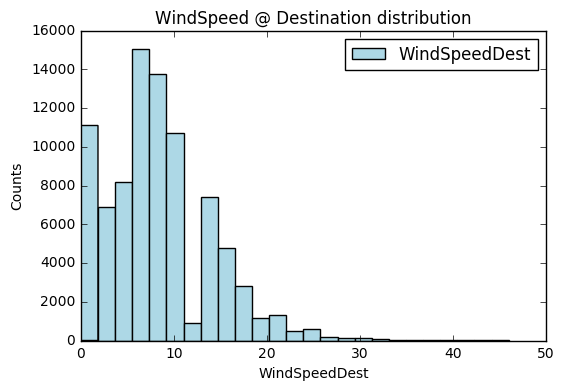

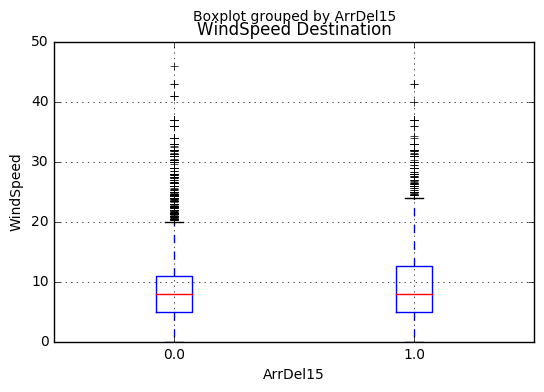

In [31]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt
## %%local creates a pandas data-frame on the head node memory, from spark data-frame, 
## which can then be used for plotting. Here, sampling data is a good idea, depending on the memory of the head node

# TIP BY PAYMENT TYPE AND PASSENGER COUNT
ax1 = sqlResultsPD[['WindSpeedDest']].plot(kind='hist', bins=25, facecolor='lightblue')
ax1.set_title('WindSpeed @ Destination distribution')
ax1.set_xlabel('WindSpeedDest'); ax1.set_ylabel('Counts');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

# TIP BY PASSENGER COUNT
ax2 = sqlResultsPD.boxplot(column=['WindSpeedDest'], by=['ArrDel15'])
ax2.set_title('WindSpeed Destination')
ax2.set_xlabel('ArrDel15'); ax2.set_ylabel('WindSpeed');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()


----------------------------------
## Feature engineering, transformation and data preparation for modeling

#### Split data into train/test. Training fraction will be used to create model, and testing fraction will be used to evaluate model.

In [7]:
trainingFraction = 0.75; testingFraction = (1-trainingFraction);
seed = 1234;

# SPLIT SAMPLED DATA-FRAME INTO TRAIN/TEST, WITH A RANDOM COLUMN ADDED FOR DOING CV (SHOWN LATER)
trainPartition, testPartition = train_df.randomSplit([trainingFraction, testingFraction], seed=seed);

# CACHE DATA FRAMES IN MEMORY
trainPartition.persist(); trainPartition.count()
testPartition.persist(); testPartition.count()

trainPartition.createOrReplaceTempView("TrainPartition")
testPartition.createOrReplaceTempView("TestPartition")

#### Filter out null values, and filter test data by categories of features to ensure transformations trained on test data will fit the the test data

In [8]:
## EXAMPLES BELOW ALSO SHOW HOW TO USE SQL DIRECTLY ON DATAFRAMES
trainPartitionFilt = trainPartition.filter("ArrDel15 is not NULL and DayOfMonth is not NULL and DayOfWeek is not NULL \
                and Carrier is not NULL and OriginAirportID is not NULL and DestAirportID is not NULL \
                and CRSDepTime is not NULL and VisibilityOrigin is not NULL and DryBulbCelsiusOrigin is not NULL \
                and DewPointCelsiusOrigin is not NULL and RelativeHumidityOrigin is not NULL \
                and WindSpeedOrigin is not NULL and AltimeterOrigin is not NULL \
                and VisibilityDest is not NULL and DryBulbCelsiusDest is not NULL \
                and DewPointCelsiusDest is not NULL and RelativeHumidityDest is not NULL \
                and WindSpeedDest is not NULL and AltimeterDest is not NULL ")
trainPartitionFilt.persist(); trainPartitionFilt.count()
trainPartitionFilt.createOrReplaceTempView("TrainPartitionFilt")

testPartitionFilt = testPartition.filter("ArrDel15 is not NULL and DayOfMonth is not NULL and DayOfWeek is not NULL \
                and Carrier is not NULL and OriginAirportID is not NULL and DestAirportID is not NULL \
                and CRSDepTime is not NULL and VisibilityOrigin is not NULL and DryBulbCelsiusOrigin is not NULL \
                and DewPointCelsiusOrigin is not NULL and RelativeHumidityOrigin is not NULL \
                and WindSpeedOrigin is not NULL and AltimeterOrigin is not NULL \
                and VisibilityDest is not NULL and DryBulbCelsiusDest is not NULL \
                and DewPointCelsiusDest is not NULL and RelativeHumidityDest is not NULL \
                and WindSpeedDest is not NULL and AltimeterDest is not NULL") \
                .filter("OriginAirportID IN (SELECT distinct OriginAirportID FROM TrainPartitionFilt) \
                    AND ORIGIN IN (SELECT distinct ORIGIN FROM TrainPartitionFilt) \
                    AND DestAirportID IN (SELECT distinct DestAirportID FROM TrainPartitionFilt) \
                    AND DEST IN (SELECT distinct DEST FROM TrainPartitionFilt) \
                    AND Carrier IN (SELECT distinct Carrier FROM TrainPartitionFilt) \
                    AND CRSDepTime IN (SELECT distinct CRSDepTime FROM TrainPartitionFilt) \
                    AND DayOfMonth in (SELECT distinct DayOfMonth FROM TrainPartitionFilt) \
                    AND DayOfWeek in (SELECT distinct DayOfWeek FROM TrainPartitionFilt)")
testPartitionFilt.persist(); testPartitionFilt.count()
testPartitionFilt.createOrReplaceTempView("TestPartitionFilt")

#### Indexing features using pipeline transformations

In [9]:
# TRANSFORM SOME FEATURES BASED ON MLLIB TRANSFORMATION FUNCTIONS
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer, Bucketizer, Binarizer

sI0 = StringIndexer(inputCol = 'ArrDel15', outputCol = 'ArrDel15_ind'); bin0 = Binarizer(inputCol = 'ArrDel15_ind', outputCol = 'ArrDel15_bin', threshold = 0.5);
sI1 = StringIndexer(inputCol="Carrier", outputCol="Carrier_ind");
transformPipeline = Pipeline(stages=[sI0, bin0, sI1]);

transformedTrain = transformPipeline.fit(trainPartition).transform(trainPartitionFilt)
transformedTest = transformPipeline.fit(trainPartition).transform(testPartitionFilt)

transformedTrain.persist(); transformedTrain.count();
transformedTest.persist(); transformedTest.count();

213808


----------------------------------
## Train a regression model: Predict the amount of tip paid for taxi trips

### Define the training formula and transformations that's to be applied to all training pipelines

In [10]:
from pyspark.ml.feature import RFormula

## DEFINE REGRESSION FURMULA
regFormula = RFormula(formula="ArrDel15_ind ~ \
                        DayOfMonth + DayOfWeek + Carrier_ind + OriginAirportID + DestAirportID + CRSDepTime \
                        + VisibilityOrigin + DryBulbCelsiusOrigin + DewPointCelsiusOrigin \
                        + RelativeHumidityOrigin + WindSpeedOrigin + AltimeterOrigin \
                        + VisibilityDest + DryBulbCelsiusDest + DewPointCelsiusDest \
                        + RelativeHumidityDest + WindSpeedDest + AltimeterDest");

## DEFINE INDEXER FOR CATEGORIAL VARIABLES
## NOTE: Some categorical features (such as origin and destination airports have > 240 categories, which is why 
## maxCategories is set to 250)
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=250)

### Train Elastic Net classification model, and evaluate performance on test data

In [13]:
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from sklearn.metrics import roc_curve,auc

## DEFINE ELASTIC NET REGRESSOR
eNet = LogisticRegression(featuresCol="indexedFeatures", maxIter=25, regParam=0.01, elasticNetParam=0.5)

## TRAINING PIPELINE: Fit model, with formula and other transformations
model = Pipeline(stages=[regFormula, featureIndexer, eNet]).fit(transformedTrain)

# SAVE MODEL
datestamp = datetime.datetime.now().strftime('%m-%d-%Y-%s');
fileName = "logisticRegModel_" + datestamp;
logRegDirfilename = modelDir + fileName;
model.save(logRegDirfilename)

## Evaluate model on test set
predictions = model.transform(transformedTest)
predictionAndLabels = predictions.select("label","prediction").rdd
predictions.select("label","probability").createOrReplaceTempView("tmp_results")

metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.6811543852577218

#### Bring predictions to the local pandas dataframe for plotting using matplotlib
NOTE: -n -1 means all of the data from predictions_pddf are brought to the local dataframe [You cannot do this for large dataframes]

In [27]:
%%sql -q -o predictions_pddf -n -1
SELECT label, probability from tmp_results

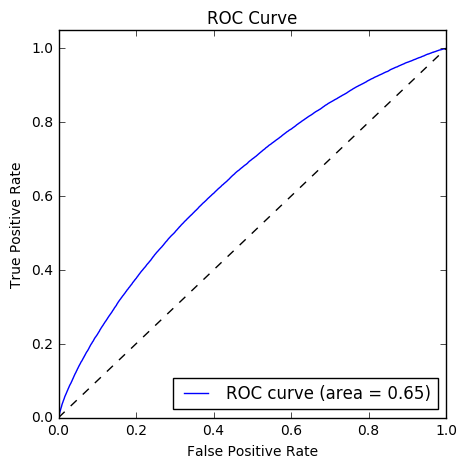

In [24]:
%%local
## PLOT ROC CURVE AFTER CONVERTING PREDICTIONS TO A PANDAS DATA FRAME
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
%matplotlib inline

labels = predictions_pddf["label"]
prob = []
for dv in predictions_pddf["probability"]:
    prob.append(list(dv.values())[1][1])
    
fpr, tpr, thresholds = roc_curve(labels, prob, pos_label=1);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate');
plt.title('ROC Curve'); plt.legend(loc="lower right");
plt.show()

### Train Gradient Boosting Tree binary classification model, and evaluate performance on test data

In [39]:
from pyspark.ml.regression import GBTRegressor

## DEFINE GRADIENT BOOSTING TREE CLASSIFIER
gBT = GBTRegressor(featuresCol="indexedFeatures", maxIter=10, maxBins = 250)

## TRAINING PIPELINE: Fit model, with formula and other transformations
model = Pipeline(stages=[regFormula, featureIndexer, gBT]).fit(transformedTrain)

# SAVE MODEL
datestamp = datetime.datetime.now().strftime('%m-%d-%Y-%s');
fileName = "gbtModel_" + datestamp;
gbtDirfilename = modelDir + fileName;
model.save(gbtDirfilename)

## Evaluate model on test set
predictions = model.transform(transformedTest)
predictionAndLabels = predictions.select("label","prediction").rdd

metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.7369255957114815

### Train a random forest binary classification model using the Pipeline function, save, and evaluate on test data set

In [42]:
from pyspark.ml.classification import RandomForestClassifier

## DEFINE RANDOM FOREST CLASSIFIER
randForest = RandomForestClassifier(featuresCol = 'indexedFeatures', labelCol = 'label', numTrees=20, \
                                   maxDepth=6, maxBins=250)

## TRAINING PIPELINE: Fit model, with formula and other transformations
model = Pipeline(stages=[regFormula, featureIndexer, randForest]).fit(transformedTrain)

# SAVE MODEL
datestamp = datetime.datetime.now().strftime('%m-%d-%Y-%s');
fileName = "rfModel_" + datestamp;
rfDirfilename = modelDir + fileName;
model.save(rfDirfilename)

## Evaluate model on test set
predictions = model.transform(transformedTest)
predictionAndLabels = predictions.select("label","prediction").rdd

metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.7474663414748935


----------------------------------
## Hyper-parameter tuning: Train a random forest model using cross-validation

In [44]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

## DEFINE RANDOM FOREST MODELS
## DEFINE RANDOM FOREST CLASSIFIER
randForest = RandomForestClassifier(featuresCol = 'indexedFeatures', labelCol = 'label', numTrees=20, \
                                   maxDepth=6, maxBins=250)


## DEFINE MODELING PIPELINE, INCLUDING FORMULA, FEATURE TRANSFORMATIONS, AND ESTIMATOR
pipeline = Pipeline(stages=[regFormula, featureIndexer, randForest])

## DEFINE PARAMETER GRID FOR RANDOM FOREST
paramGrid = ParamGridBuilder() \
    .addGrid(randForest.numTrees, [10, 25, 50]) \
    .addGrid(randForest.maxDepth, [3, 5, 7]) \
    .build()

## DEFINE CROSS VALIDATION
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
                          numFolds=3)

## TRAIN MODEL USING CV
cvModel = crossval.fit(transformedTrain)

## Evaluate model on test set
predictions = cvModel.transform(transformedTest)
predictionAndLabels = predictions.select("label","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

## SAVE THE BEST MODEL
datestamp = datetime.datetime.now().strftime('%m-%d-%Y-%s');
fileName = "CV_RandomForestRegressionModel_" + datestamp;
CVDirfilename = modelDir + fileName;
cvModel.bestModel.save(CVDirfilename);

Area under ROC = 0.755388760846736


----------------------------------
## Load a saved pipeline model and evaluate it on test data set

In [43]:
from pyspark.ml import PipelineModel

savedModel = PipelineModel.load(logRegDirfilename)

## Evaluate model on test set
predictions = savedModel.transform(transformedTest)
predictionAndLabels = predictions.select("label","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.6811543852577218

## Load and transform an independent validation data-set, and evaluate the saved pipeline model

### Note that this validation data, by design, has a different format than the original trainig data. By grangling and transformations, we make the data format the same as the training data for the purpose of scoring.

In [55]:
## READ IN DATA FRAME FROM PARQUET
validfilename = dataDir + "ValidationData";
validPartition = spark.read.parquet(validfilename)
validPartition.persist(); validPartition.count()
validPartition.printSchema()

root
 |-- ArrDel15: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Carrier: string (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DestAirportID: integer (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- VisibilityOrigin: double (nullable = true)
 |-- DryBulbCelsiusOrigin: double (nullable = true)
 |-- DewPointCelsiusOrigin: double (nullable = true)
 |-- RelativeHumidityOrigin: double (nullable = true)
 |-- WindSpeedOrigin: double (nullable = true)
 |-- AltimeterOrigin: double (nullable = true)
 |-- VisibilityDest: double (nullable = true)
 |-- DryBulbCelsiusDest: double (nullable = true)
 |-- DewPointCelsiusDest: double (nullable = true)
 |-- RelativeHumidityDest: double (nullable = true)
 |-- WindSpeedDest: double (nullable = true)
 |-

#### It is a good idea to filter the validation dataset for null values, as well as, categorical values not observed in the training data set. Otherwise, errors could be thrown at scoring time

In [50]:
validPartitionFilt = validPartition.filter("ArrDel15 is not NULL and DayOfMonth is not NULL and DayOfWeek is not NULL \
                and Carrier is not NULL and OriginAirportID is not NULL and DestAirportID is not NULL \
                and CRSDepTime is not NULL and VisibilityOrigin is not NULL and DryBulbCelsiusOrigin is not NULL \
                and DewPointCelsiusOrigin is not NULL and RelativeHumidityOrigin is not NULL \
                and WindSpeedOrigin is not NULL and AltimeterOrigin is not NULL \
                and VisibilityDest is not NULL and DryBulbCelsiusDest is not NULL \
                and DewPointCelsiusDest is not NULL and RelativeHumidityDest is not NULL \
                and WindSpeedDest is not NULL and AltimeterDest is not NULL") \
                .filter("OriginAirportID IN (SELECT distinct OriginAirportID FROM TrainPartitionFilt) \
                    AND ORIGIN IN (SELECT distinct ORIGIN FROM TrainPartitionFilt) \
                    AND DestAirportID IN (SELECT distinct DestAirportID FROM TrainPartitionFilt) \
                    AND DEST IN (SELECT distinct DEST FROM TrainPartitionFilt) \
                    AND Carrier IN (SELECT distinct Carrier FROM TrainPartitionFilt) \
                    AND CRSDepTime IN (SELECT distinct CRSDepTime FROM TrainPartitionFilt) \
                    AND DayOfMonth in (SELECT distinct DayOfMonth FROM TrainPartitionFilt) \
                    AND DayOfWeek in (SELECT distinct DayOfWeek FROM TrainPartitionFilt)")
validPartitionFilt.persist(); validPartitionFilt.count()
validPartitionFilt.createOrReplaceTempView("ValidPartitionFilt")

#### We need to apply the same transformation to the validation data as the ones that were applied to the training set, as in the transformPipeline function defined above

In [52]:
transformedValid = transformPipeline.fit(trainPartition).transform(validPartitionFilt)

#### Load saved model, score validation data and evaluate

In [70]:
savedModel = PipelineModel.load(logRegDirfilename)
predictions = savedModel.transform(transformedValid)
predictionAndLabels = predictions.select("label","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.6944995086466054